https://ljm565.github.io/contents/ManifoldLearning3.html

https://www.dacon.io/en/codeshare/2567

https://wikidocs.net/3413

https://techblog-history-younghunjo1.tistory.com/130

머신러닝을 위한 가장 기본적인 데이터셋인 MNIST 데이터셋은 0 ~ 9까지의 숫자 손글씨를 저장해놓은 데이터 베이스이다.

![image.png](attachment:image.png)

MNIST 데이터 셋은 28x28의 1채널 흑백 영상이고 원본 데이터는 각 픽셀별 0 ~ 255까지 8bit 정수형 변수를 갖는다. 이를 일반적으로 활용할 때에는 픽셀별 값을 아래와 같이 0 ~ 1사이로 표준화 하여 사용한다. 

![image-2.png](attachment:image-2.png)

1. 아래와 같이 MNIST 데이터 셋을 TF 에서 다운로드 받으면 총 60000개의 학습용 데이터와 10000개의 검증용 데이터를 다운 받을 수 있다.

In [ ]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


2. 위에서 다운받은 MNIST 데이터 셋중 학습용 데이터 셋을 이용하여 MNIST 데이터 셋을 분류할 수 있는 간단한 Covolutional Neural Network 분류기를 만들과, 검증용 데이터 셋으로 성능을 검증하시오.
 - 데이터 전처리 및 신경망의 모델은 사용자가 선택한 전략에 따라 구현하시오.

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
x_train.dtype, type(x_train)

(dtype('uint8'), numpy.ndarray)

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
### MNIST Classifier with CNN 

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

  
learning_rate = 0.001
training_epochs = 15
batch_size = 100


x_train = torch.FloatTensor(x_train).unsqueeze(1)
y_train = torch.LongTensor(y_train)

x_test = torch.FloatTensor(x_test).unsqueeze(1)
y_test = torch.LongTensor(y_test)

train_set = TensorDataset(x_train, y_train)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)





In [ ]:
x_train.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
# CNN 모델 클래스 (Simple)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        # 첫번째층
        # Img shape=(?, 28, 28, 1)   ?는 배치 사이즈
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3, stride=1, padding=1),

            
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # Img shape=(?, 14, 14, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  
        out = self.fc(out)
        return out
    

    
# 모델 세팅
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [ ]:
!pip install pytorch_model_summary
import pytorch_model_summary
print(pytorch_model_summary.summary(model, torch.zeros(100,1, 28, 28), show_input=True))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
-------------------------------------------------------------------------
      Layer (type)           Input Shape         Param #     Tr. Param #
          Conv2d-1      [100, 1, 28, 28]             320             320
            ReLU-2     [100, 32, 28, 28]               0               0
       MaxPool2d-3     [100, 32, 28, 28]               0               0
          Conv2d-4     [100, 32, 14, 14]          18,496          18,496
            ReLU-5     [100, 64, 14, 14]               0               0
       MaxPool2d-6     [100, 64, 14, 14]               0               0
          Linear-7           [100, 3136]          31,370          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
-------------------------------------------------------------------------


In [ ]:
# Train

model.train()

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader: 
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 1.03180707
[Epoch:    2] cost = 0.100815795
[Epoch:    3] cost = 0.0681101158
[Epoch:    4] cost = 0.0618252456
[Epoch:    5] cost = 0.0523590334
[Epoch:    6] cost = 0.0508273579
[Epoch:    7] cost = 0.0477588698
[Epoch:    8] cost = 0.0426512994
[Epoch:    9] cost = 0.0358017571
[Epoch:   10] cost = 0.0337309651
[Epoch:   11] cost = 0.0333620459
[Epoch:   12] cost = 0.0294400323
[Epoch:   13] cost = 0.0253043883
[Epoch:   14] cost = 0.0205692779
[Epoch:   15] cost = 0.0236756206


In [ ]:
# Test 
with torch.no_grad():
    model.eval()
    
    X_test = x_test.float().to(device)
    Y_test = y_test.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9817000031471252


In [ ]:
torch.save(model, 'Simple Mnist Classifier.pt')

3. 아래와 MNIST 데이터셋에 약간의 강제 잡음을 추가한 데이터를 생성하였다.
![image-3.png](attachment:image-3.png) ![image-2.png](attachment:image-2.png)

In [ ]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
### MNIST Classifier with real hand writing
import tensorflow as tf
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

1. 위와 같이 noise가 추가 된, noise 데이터와 원본 데이터를 활용하여, noise를 제거하여 원본데이터처럼 복원을 해주는  denoising auto encoder알고리즘을 구현하시오.
 - AE의 네트워크 구조등은 직접 판단하여 구현하시오.

In [ ]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
### MNIST Classifier with real hand writing
import tensorflow as tf
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

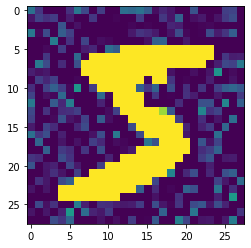

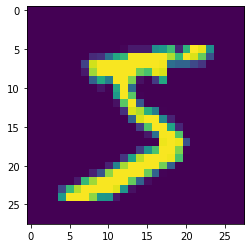

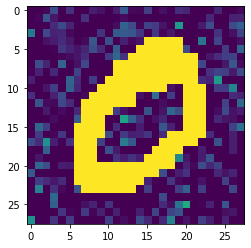

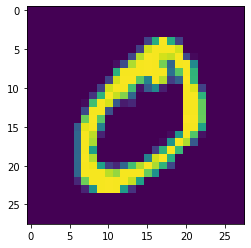

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_train_noisy[0])
plt.show()
plt.imshow(x_train[0])
plt.show()
plt.imshow(x_train_noisy[1])
plt.show()
plt.imshow(x_train[1])
plt.show()

In [ ]:
x_train_noisy[0]

<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.20067427e-02,
        4.26898059e-03, 1.88149676e-01, 2.45288655e-01, 1.25261977e-01,
        0.00000000e+00, 0.00000000e+00, 1.40135303e-01, 1.59292534e-01,
        0.00000000e+00, 8.13632682e-02, 0.00000000e+00, 1.28385261e-01,
        0.00000000e+00, 0.00000000e+00, 4.19633500e-02, 2.95329839e-01,
        2.65817374e-01, 0.00000000e+00, 5.69620617e-02, 2.19507337e-01,
        5.33320904e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.29205543e-01, 3.76192421e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.89306611e-01, 0.00000000e+00, 3.06461364e-01, 9.70039070e-02,
        0.00000000e+00, 0.00000000e+00, 2.13019654e-01, 2.74998993e-01,
        1.29828095e-01, 1.04375286e-02, 2.59844035e-01, 0.00000000e+00,
        0.00000000e+00, 1.06788864e-02, 0.00000000e+00, 0.00000000e+00,
        1.877

(array([348.,  31.,  37.,  44.,  35.,  29.,  20.,  22.,  19.,   9.,   6.,
          5.,   6.,   3.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1., 165.]),
 array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
        0.16666667, 0.2       , 0.23333333, 0.26666668, 0.3       ,
        0.33333334, 0.36666667, 0.4       , 0.43333334, 0.46666667,
        0.5       , 0.53333336, 0.56666666, 0.6       , 0.6333333 ,
        0.6666667 , 0.7       , 0.73333335, 0.76666665, 0.8       ,
        0.8333333 , 0.8666667 , 0.9       , 0.93333334, 0.96666664,
        1.        ], dtype=float32),
 <a list of 30 Patch objects>)

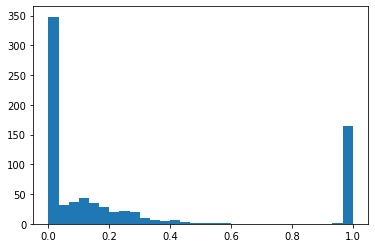

In [ ]:
plt.hist(x_train_noisy[0].numpy().reshape(-1, 1), bins= 30)

(array([639.,  11.,   6.,  11.,   6.,   9.,  11.,  12.,  11.,  68.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

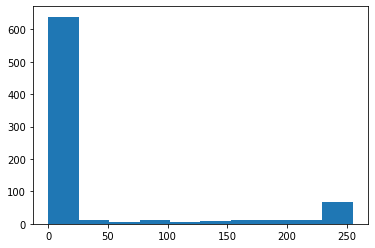

In [ ]:
plt.hist(x_train[0].reshape(-1, 1))

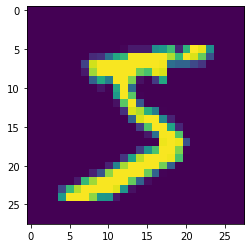

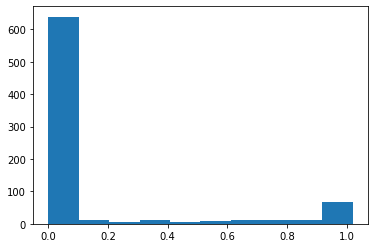

In [ ]:
## noisy set과 raw data 범주 맞춰주기

x_train_rev = x_train / 250
x_test_rev = x_test / 250

plt.imshow(x_train_rev[0])
plt.show()

plt.hist(x_train_rev[0].reshape(-1, 1))
plt.show()

In [ ]:
# 모델 클래스 정의

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        # 28 ,28
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size =3 , stride=1, padding =1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        #28 ,28
        nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=3, stride = 1 , padding =1 ),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 28 ,28 = > 14, 14
        nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, stride = 1 , padding =1 ),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # 14, 14 => 7, 7 ,256
        nn.Conv2d(in_channels = 128, out_channels= 256, kernel_size=3, stride = 1 , padding =1 ),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)

    )

    self.decoder = nn.Sequential(
        
        # 7, 7, 256
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size =3 , stride=1, padding =1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        # 7, 7, 128 => 14, 14, 64
        nn.ConvTranspose2d(in_channels = 128, out_channels=64, kernel_size=2, stride = 2 , padding = 0 ),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 14, 14, 64 =>  28, 28, 32
        nn.ConvTranspose2d(in_channels = 64, out_channels= 32, kernel_size= 2, stride = 2 , padding = 0 ),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # 28, 28, 32 => 28, 28, 1
        nn.ConvTranspose2d(in_channels = 32, out_channels=1, kernel_size=3, stride = 1 , padding =1 ),
        nn.ReLU(),


    )

  def forward(self, x):
    latent_var = self.encoder(x)
    output = self.decoder(latent_var)

    return output, latent_var

In [ ]:
!pip install pytorch_model_summary
import pytorch_model_summary

model = AE()
print(pytorch_model_summary.summary(model, torch.zeros(100,1, 28, 28), show_input=True))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [100, 1, 28, 28]             320             320
        BatchNorm2d-2      [100, 32, 28, 28]              64              64
               ReLU-3      [100, 32, 28, 28]               0               0
             Conv2d-4      [100, 32, 28, 28]          18,496          18,496
        BatchNorm2d-5      [100, 64, 28, 28]             128             128
               ReLU-6      [100, 64, 28, 28]               0               0
             Conv2d-7      [100, 64, 28, 28]          73,856          73,856
        BatchNorm2d-8     [100, 128, 28, 28]             256             256
               ReLU-9     [100, 128, 28, 28]               0               0
         MaxPool2d-10     [100, 128, 28, 28]         

In [ ]:
x_train_noisy.shape, type(x_train_noisy)

(TensorShape([60000, 28, 28]), tensorflow.python.framework.ops.EagerTensor)

In [ ]:
# 모델 세팅

from torch.utils.data.dataset import Dataset


learning_rate = 0.001
training_epochs = 3
batch_size = 100

model = AE()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

X_train = torch.FloatTensor(x_train_noisy.numpy()).unsqueeze(1)
Y_train = torch.FloatTensor(x_train_rev).unsqueeze(1)


train_set = TensorDataset(X_train, Y_train)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)
total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))



총 배치의 수 : 600


In [ ]:
# Train  : epoch은 3회만 실시하였습니다.... (코랩에서 자꾸 세션이 끊어져서 에폭을 소량 실시하였습니다...)
for epoch in range(training_epochs):
  
  model.train()

  avg_cost = 0

  for X, Y in train_loader:

      optimizer.zero_grad()
      hypothesis, _ = model(X)
      cost = criterion(hypothesis, Y)
      cost.backward()
      optimizer.step()
      avg_cost += cost / total_batch

  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
  torch.save(model, 'AE 3_epoch.pt')

[Epoch:    1] cost = 0.0601921976
[Epoch:    2] cost = 0.0549356118
[Epoch:    3] cost = 0.0545781516


In [ ]:
model = torch.load('AE 3_epoch.pt')

In [ ]:
# Test 

X_test = torch.FloatTensor(x_test_noisy.numpy()).unsqueeze(1)
Y_test = torch.FloatTensor(x_test_rev).unsqueeze(1)


with torch.no_grad():
    model.eval()
    
    prediction, _ = model(X_test)

    score = criterion(prediction, Y_test)
 
    print('Score:', score)

Score: tensor(0.0553)


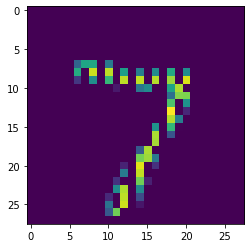

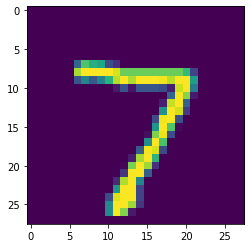

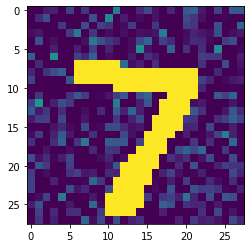

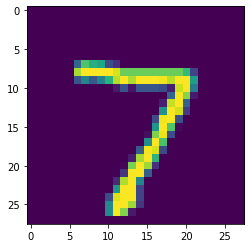

In [ ]:
## 이미지로 확인해보기

# : 두꺼움은 복원되었습니다, 하지만 본래 값은 일부 소실되었습니다 epoch을 더 늘리면 될수도 있을 것 같습니다
# : 과적합시 모델을 축소하도록 하겠습니다. 
# : 기본적인 개념을 보시는거라 생각하여, 하이퍼 파라미터 튜닝이나 규제 등은 적용하지 않았습니다.
# : 감사합니다.

import matplotlib.pyplot as plt

# prediction한 data 이미지화
plt.imshow(prediction[0].squeeze().detach().numpy())
plt.show()

# 타겟 data 이미지화
plt.imshow(Y_test[0].squeeze().detach().numpy())
plt.show()

# 노이즈 추가된 data 이미지화
plt.imshow(x_test_noisy[0])
plt.show()

# 원본 타겟 data 이미지화
plt.imshow(x_test[0])
plt.show()

